## Regularized Linear Regression and Bias v.s. Variance
*Implement regularized linear regression and use it to study models with dierent bias-variance properties*

In [1]:
from numpy import *
%pylab inline
import scipy.optimize as op
import pandas as pd
import os
import scipy.io as sio

Populating the interactive namespace from numpy and matplotlib


*Import data*

In [2]:
data = sio.loadmat("ex5data1.mat")

In [3]:
data.keys()

['ytest',
 'yval',
 '__header__',
 '__globals__',
 'Xtest',
 'Xval',
 'y',
 'X',
 '__version__']

In [4]:
X = data["X"] # training data
y = data["y"]

Xval = data["Xval"] # cross-validation data for determining the regularization parameter
yval = data["yval"]

Xtest = data["Xtest"] # test data to evaluate the performance of the model
ytest = data["ytest"]

In [5]:
X.shape, y.shape, Xval.shape, Xtest.shape

((12L, 1L), (12L, 1L), (21L, 1L), (21L, 1L))

In [6]:
# number of examples
m = len(y)

*Visualize test data*

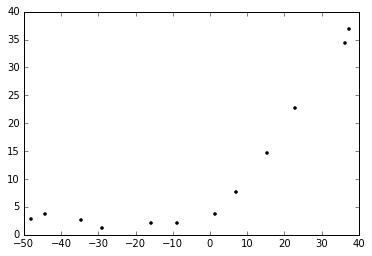

In [7]:
figure
plot(X,y,'k.')

*Define cost function, gradient for regularized linear regression*

In [8]:
def Evaluate(theta,X):
    theta = expand_dims(theta,axis=1)
    return dot(X,theta)

In [9]:
def Cost(theta,X,y,LR):
    # mean squared difference
    theta = expand_dims(theta,axis=1)
    cost = sum((dot(X,theta)-y)**2)
    # regularization: sum of parameters (minus the first one)
    cost += LR*sum(theta[1:]**2)
    cost = cost/(2*len(y))
    return cost

In [10]:
X1 = insert(X, 0, values=ones(m), axis=1)
theta1 = ones((2))

In [11]:
Cost(theta1,X1,y,1)

303.99319222026429

In [12]:
def gradient(theta,X,y,LR):
    m = len(y)
    theta = expand_dims(theta,axis=1)
    theta0 = copy(theta)
    theta0[0,0]=0
    #print(theta0)
    #print((dot(X,theta)-y))
    #print(dot(X.T,(dot(X,theta)-y)))

    grad = (dot(X.T,(dot(X,theta)-y))+LR*theta0)/m
    return grad

In [13]:
gradient(theta1,X1,y,1)

array([[ -15.30301567],
       [ 598.25074417]])

*Define function to find parameters theta (fmin.x) by minimizing cost.*

In [14]:
def trainLinearRegression(X,y,LR):
    theta0 = zeros((shape(X)[1]))
    fmin = op.minimize(fun=Cost, x0=theta0, args=(X, y, LR), method='TNC', jac=gradient, options={'maxiter': 350})
    #print(fmin.success)
    return fmin.x

*Find best fit parameters theta*

In [15]:
theta = trainLinearRegression(X1,y,0)
theta

array([ 13.08790351,   0.36777923])

*A line is obviously not a good fit to the data*

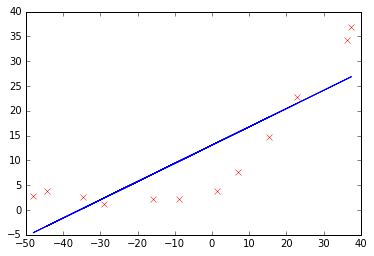

In [16]:
figure
plot(X,y,'rx')
yf = Evaluate(theta,X1)
plot(X,yf,'b')

*Define learning curve function: To plot the learning curve, we need a training and cross validation set error for different training set sizes. To obtain different training set sizes, use different subsets of the original training set X.*

In [17]:
def learningCurve(X, y, Xval, yval, LR):
    m = len(y)
    
    # add constant term to X
    X = insert(X, 0, values=ones(m), axis=1)
    Xval = insert(Xval, 0, values=ones(len(Xval)), axis=1)
    
    # take each subset
    error_train = zeros(m-1)
    error_val = zeros(m-1)
    for ii in range(2,m+1):
        Xsub = X[:ii,:]
        ysub = y[:ii,:]
        
        # fit to find theta
        theta = trainLinearRegression(Xsub,ysub,LR)
        error_train[ii-2] = Cost(theta,Xsub,ysub,0)
        error_val[ii-2] = Cost(theta,Xval,yval,0)
    
    return error_train, error_val

*Plot the training set and validation set error vs. the size of the training set. The learning curve reflects high bias because the training and cross-validation error remain high as the training set size increases.*

In [18]:
(error_train, error_val) = learningCurve(X, y, Xval, yval, 0)

In [19]:
n = range(2,len(y)+1)
n

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

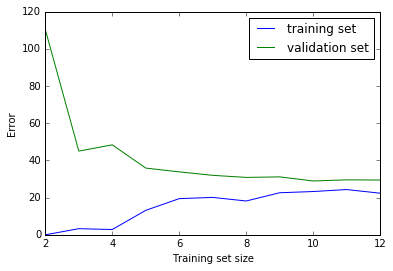

In [20]:
figure
p1, = plot(n,error_train)
p2, = plot(n,error_val)
xlabel('Training set size')
ylabel('Error')
legend([p1,p2],['training set','validation set'])

*Add polynomial features up to degree 8 (and feature normalization) to improve the quality of fit.*

In [21]:
def polyFeatures(X,p):
    Xp = zeros((len(X),p))
    for ii in range(0,p):
        Xp[:,ii] = X[:,0]**(ii+1)
    return Xp

In [22]:
def featureNormalize(X):
    mu = mean(X,axis=0)
    sigma = std(X,axis=0)
    X_norm = (X-mu)/sigma
    return X_norm, mu, sigma

In [23]:
X8 = polyFeatures(X,8)
(X_norm, mu, sigma) = featureNormalize(X8)
Xn = insert(X_norm, 0, values=ones(len(y)), axis=1)
X_norm.shape

(12L, 8L)

In [24]:
theta = trainLinearRegression(Xn,y,1)

In [25]:
Xval8 = polyFeatures(Xval,8)
Xval8 = (Xval8-mu)/sigma
#Xval8 = insert(Xval8, 0, values=ones(len(yval)), axis=1)
Xval8.shape

(21L, 8L)

*PLot the data with the polynomial fit. lambda = 0 has low bias, high variance; lambda = 100 has high bias, low variance.*

In [26]:
def plotFit(min_x, max_x, mu, sigma, theta, p, c):
    x = linspace(min_x,max_x,50)
    x = expand_dims(x,axis=1)
    Xpoly = polyFeatures(x,p)
    Xpoly = (Xpoly-mu)/sigma
    Xpoly = insert(Xpoly, 0, values=ones(50), axis=1)
    
    yf = Evaluate(theta,Xpoly)
    plot(x,yf,c)

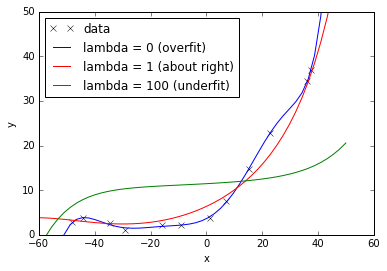

In [27]:
figure
plot(X,y,'kx')
theta = trainLinearRegression(Xn,y,0)
plotFit(-60,50,mu,sigma,theta,8,'b')
theta = trainLinearRegression(Xn,y,1)
plotFit(-60,50,mu,sigma,theta,8,'r')
theta = trainLinearRegression(Xn,y,100)
plotFit(-60,50,mu,sigma,theta,8,'g')
ylim(0,50)
xlabel('x')
ylabel('y')
legend(['data','lambda = 0 (overfit)','lambda = 1 (about right)','lambda = 100 (underfit)'],loc='best')

*Plot learning curves for 3 values of the regularizon parameter. It's clear that lambda = 1 gives the best results (lowest error).*

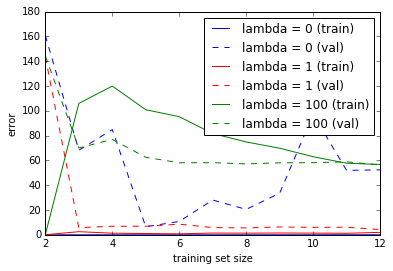

In [28]:
figure
(error_train, error_val) = learningCurve(X_norm, y, Xval8, yval, 0)
plot(range(2,len(error_train)+2),error_train,'b')
plot(range(2,len(error_train)+2),error_val,'b--')
(error_train, error_val) = learningCurve(X_norm, y, Xval8, yval, 1)
plot(range(2,len(error_train)+2),error_train,'r')
plot(range(2,len(error_train)+2),error_val,'r--')
(error_train, error_val) = learningCurve(X_norm, y, Xval8, yval, 100)
plot(range(2,len(error_train)+2),error_train,'g')
plot(range(2,len(error_train)+2),error_val,'g--')
legend(['lambda = 0 (train)','lambda = 0 (val)','lambda = 1 (train)','lambda = 1 (val)','lambda = 100 (train)','lambda = 100 (val)'],loc='best')
xlabel('training set size')
ylabel('error')

*Now, systematically vary the regularization parameter (LR) when optimizing to the training set, and measure the error in the validation set. The lowest validation set error will be used to choose the appropriate LR for the test data.*

In [29]:
 def validationCurve(X, y, Xval, yval):
    
    LR_vec = array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
    m = len(y)
    LR_len = len(LR_vec)
    
    # add constant term to X
    X = insert(X, 0, values=ones(m), axis=1)
    Xval = insert(Xval, 0, values=ones(len(Xval)), axis=1)
    
    # take each subset
    error_train = zeros(LR_len)
    error_val = zeros(LR_len)
    for ii in range(LR_len):
        
        # fit to find theta
        theta = trainLinearRegression(X,y,LR_vec[ii])
        error_train[ii] = Cost(theta,X,y,0)
        error_val[ii] = Cost(theta,Xval,yval,0)
    
    return LR_vec, error_train, error_val

In [30]:
lambda_vec = array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
lambda_vec.shape

(10L,)

In [31]:
(LR_vec, error_train, error_val) = validationCurve(X_norm, y, Xval8, yval)

*Plot the training and validation error vs. the regularization parameter. Best choice has LR ~ 3*

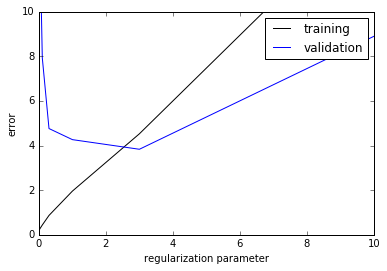

In [32]:
figure
plot(LR_vec,error_train,'k')
plot(LR_vec,error_val,'b')
ylim(0,10)
xlabel('regularization parameter')
ylabel('error')
legend(['training','validation'])

In [33]:
LR = 3
Xtest8 = polyFeatures(Xtest,8)
Xtest8 = (Xtest8-mu)/sigma
Xtest8 = insert(Xtest8, 0, values=ones(len(ytest)), axis=1)

In [34]:
theta = trainLinearRegression(Xn,y,LR)

In [35]:
Cost(theta,Xtest8,ytest,0)

3.5720430373160048